In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import numpy as np
from scipy.integrate import solve_ivp,quad,cumulative_trapezoid
import matplotlib.pyplot as plt
from params import Tz_sc, nz
from constitutive import sat,temp,perm,Phi, sat_T

In [3]:
def v(z_l,phi,N_f):
    # compute the heave rate
    int1 =  lambda z: 1-phi+(1-phi*sat(temp(z)))*Tz_sc
    int2 = lambda z: (1-phi*sat(temp(z)))**2 / perm(sat(temp(z))) 
    q1 = 1-N_f + quad(int1,0,z_l,limit=1000)[0]
    q2 = quad(int2,0,z_l,limit=1000)[0] + 1e-7
    return q1/q2

# def v(z_l,phi,N_f):
#     phi = phi
#     N_z = 0.2*z_l
#     q1 =  perm(sat(temp(z_l)))/(1-phi*sat(temp(z_l)))**2 
#     q2 = 1 - phi + (1+temp(z_l))*phi*sat_T(temp(z_l))*Tz_sc + N_z
#     return q1*q2 

In [4]:
def N(z_l,phi,v_0,N_f):
    z = np.linspace(0,z_l,1000)
    T = temp(z)
    f = v_0*(1-phi*sat(temp(z)))**2 / perm(sat(temp(z))) - (1-phi) - (1+T)*phi*sat_T(T)*Tz_sc
    N_ = N_f + cumulative_trapezoid(f, z,initial=0)
    return N_

In [5]:
def lens_init(t,y,v_i,N_f,rigid):
    z_l,phi = y[0], y[1]
    v_0 = v(z_l,phi,N_f)
    N_ = N(z_l,phi,v_0,N_f)
    return N_.min()-0.05

lens_init.terminal = True

In [6]:
def F(t,y,v_i,N_f,rigid):
    # RHS of ODE d/dt (z_l, phi) = (f_1,f_2)
    z_l,phi = y[0], y[1]
    v_0 = v(z_l,phi,N_f)
    phi_f = Phi(N_f,log=np.log)
    min_ = lambda phi: 0.5*(phi+0.01 + ((phi-0.01)**2)**0.5)
    max_ = lambda phi: 0.5*(phi+0.99 - ((phi-0.99)**2)**0.5)
    q_f = 2*v_0
    f_1 = v_i - v_0
    f_2 = (1-rigid)*(1/z_l)*((1-phi)*(v_i-v_0)+(1-phi_f)*(q_f-v_i))*max_(phi)*min_(phi)
    return [f_1,f_2]

In [7]:
def solve(v_i,N_f,rigid,t_span,y0):
    t_max = t_span[1]
    P = np.array([y0[1]])
    Z = np.array([y0[0]])
    t__ = np.array([0])
    t0 = 0
    while t0<t_max:
        sol = solve_ivp(F,t_span,y0,args=(v_i,N_f,rigid),events = lens_init,dense_output=True)
        if np.size(sol.t_events) > 0:
            t0 = np.max(sol.t_events[0])
            t = np.linspace(t_span[0],t0,1000)
            t_span = [t0,t_max]
            z_l,phi = sol.sol(t)
            v_0 = v(z_l[-1],phi[-1],N_f)
            N_ = N(z_l[-1],phi[-1],v_0,N_f)
            
            z = np.linspace(0,z_l[-1],1000)
            z_n = z[np.argmin(N_)]
            
            y0[0] = z_n
            
#             if rigid == 0:
#                 v_new = v(z_n,phi[-1],N_f) 
#                 N_new = N(z_n,phi[-1],v_0,N_f)
     
#                 # N_new = N_nonlin(z_n,N_f)
#                 y0[1] = Phi(N_new,log=np.log).mean()
                
            P = np.append(P,phi)
            Z = np.append(Z,z_l)
            t__ = np.append(t__,t)
        else:
            t = np.linspace(t0,t_max,1000)
            t_span = [t0,t_max]
            z_l,phi = sol.sol(t)
            P = np.append(P,phi)
            Z = np.append(Z,z_l)
            t__ = np.append(t__,t)
            break
    
    return P,Z,t__

In [8]:
t_span = [0,1e3]
y0 = [3,0.3]
N_f = 2
v_i = 0.035

rigid = 1
phi_r,z_l_r,t_r = solve(v_i,N_f,rigid,t_span,y0)

rigid = 0
phi,z_l,t = solve(v_i,N_f,rigid,t_span,y0)


In [9]:
heave = 0*z_l
for i in range(heave.size):
    heave[i] = v(z_l[i],phi[i],N_f)


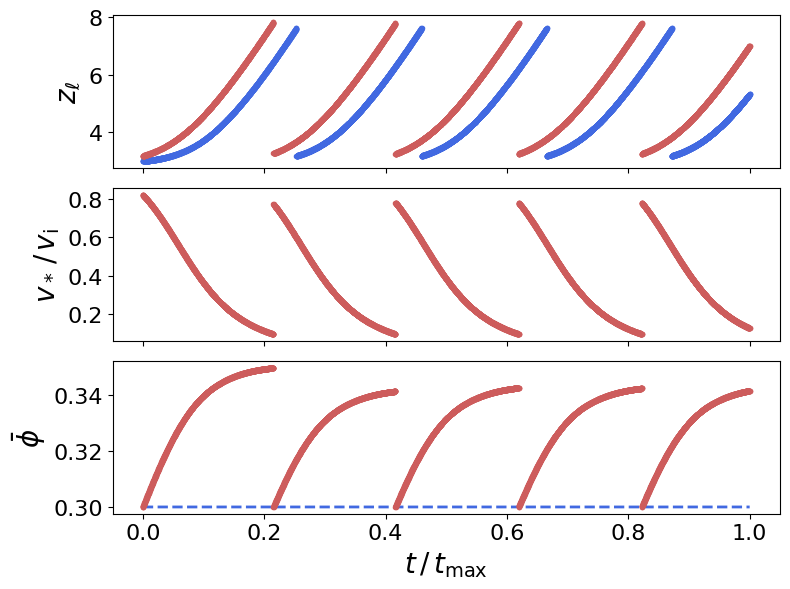

In [10]:
plt.figure(figsize=(8,6))
plt.subplot(311)
plt.plot(t_r/t_r.max(),z_l_r,marker='o',linestyle='none',markersize=3,color='royalblue',label=r'const $\phi$')
plt.plot(t/t.max(),z_l,marker='o',linestyle='none',markersize=3,color='indianred',label=r'var $\phi$')
plt.ylabel(r'$z_\ell$',fontsize=20)  
plt.gca().xaxis.set_ticklabels([])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(312)
plt.plot(t/t.max(),heave/v_i,marker='o',linestyle='none',markersize=3,color='indianred',label=r'var $\phi$')
# plt.plot(t/t.max(),heave_l/v_i,marker='o',linestyle='none',markersize=3,color='forestgreen',label=r'var $\phi$')
plt.ylabel(r'$v_*\,/\,v_\mathrm{i}$',fontsize=20)  
plt.gca().xaxis.set_ticklabels([])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(313)
plt.plot(t_r/t_r.max(),phi_r,linestyle='--',linewidth=2,color='royalblue',label=r'const $\phi$')
plt.plot(t/t.max(),phi,marker='o',linestyle='none',markersize=3,color='indianred',label=r'var $\phi$')
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.ylabel(r'$\bar{\phi}$',fontsize=20)  
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.legend(fontsize=12,loc='lower left')
plt.tight_layout()
plt.show()
plt.close()

In [14]:
# from dolfinx.mesh import create_interval
# from solvers import initialize
# from post_process import interp
# from mpi4py import MPI


# def N_nonlin(z_n,N_f):
#     z_b = 1e-3
#     domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_n])

#     # define initial condition N that satisfies the
#     # elliptic problem: D(phi,S) N']' = F(phi,S)   
#     initial = initialize(domain,N_f,eps_min=1e-10)

#     # interpolate solution, save in numpy arrays, and plot
#     z,N_nl = interp(initial,domain)
#     return N_nl